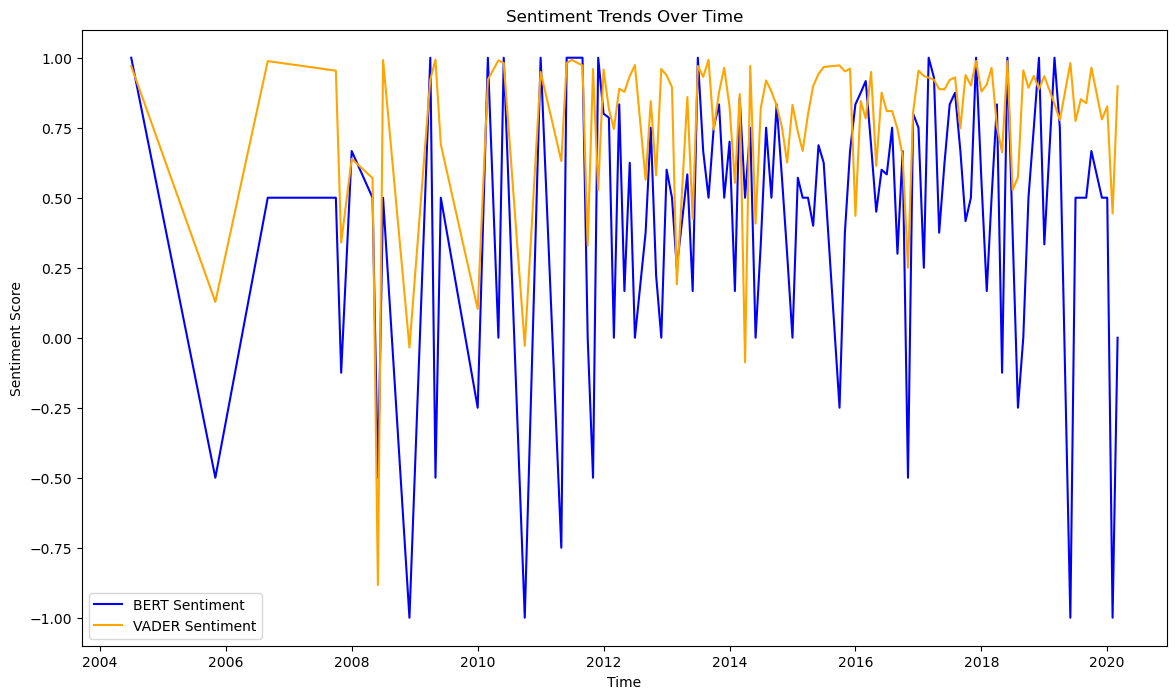

In [ ]:
#. Sentiment Trend Analysis for Food, Service, and Ambiance Over Time
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load the data
file_path = "C://Users//meghn//Downloads//Cleaned_Dolche_Vita_Reviews.csv"
df = pd.read_csv(file_path)

# Preprocess data
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['cleaned_review'] = df['Review'].str.replace(r'\W', ' ', regex=True).str.lower()

# Set up BERT for sentiment analysis
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
bert_sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# BERT Sentiment Analysis
def bert_sentiment(text):
    result = bert_sentiment_analyzer(text[:512])[0]  # Limit text length to BERT max token limit
    score = int(result['label'].split()[0])  # Convert label to numerical score (1-5 scale)
    return (score - 3) / 2  # Normalize score to -1 to 1 range

df['bert_sentiment'] = df['cleaned_review'].apply(bert_sentiment)

# VADER Sentiment Analysis
vader_analyzer = SentimentIntensityAnalyzer()
df['vader_sentiment'] = df['cleaned_review'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])

# Monthly trend analysis
df['month_year'] = df['Date'].dt.to_period('M')
monthly_sentiment = df.groupby('month_year').agg({
    'bert_sentiment': 'mean',
    'vader_sentiment': 'mean',
}).reset_index()
monthly_sentiment['month_year'] = monthly_sentiment['month_year'].dt.to_timestamp()

# Plot sentiment trends
plt.figure(figsize=(14, 8))
plt.plot(monthly_sentiment['month_year'], monthly_sentiment['bert_sentiment'], label='BERT Sentiment', color='blue')
plt.plot(monthly_sentiment['month_year'], monthly_sentiment['vader_sentiment'], label='VADER Sentiment', color='orange')
plt.title('Sentiment Trends Over Time')
plt.xlabel('Time')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meghn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 1: Food Quality - Top Words: sauce, wine, food, us, ordered
Topic 2: Customer Service - Top Words: great, wine, staff, bar, place
Topic 3: Food Quality - Top Words: good, food, nice, italian, wine
Topic 4: Food Quality - Top Words: food, restaurant, great, dolce, good
Topic 5: Food Quality - Top Words: good, food, italian, service, great

 Topic 1: 0.020*"sauce" + 0.012*"wine" + 0.012*"food" + 0.010*"us" + 0.010*"ordered"

 Topic 2: 0.010*"great" + 0.009*"wine" + 0.008*"staff" + 0.007*"bar" + 0.007*"place"

 Topic 3: 0.017*"good" + 0.012*"food" + 0.009*"nice" + 0.008*"italian" + 0.008*"wine"

 Topic 4: 0.016*"food" + 0.013*"restaurant" + 0.009*"great" + 0.009*"dolce" + 0.008*"good"

 Topic 5: 0.023*"good" + 0.019*"food" + 0.017*"italian" + 0.016*"service" + 0.013*"great"


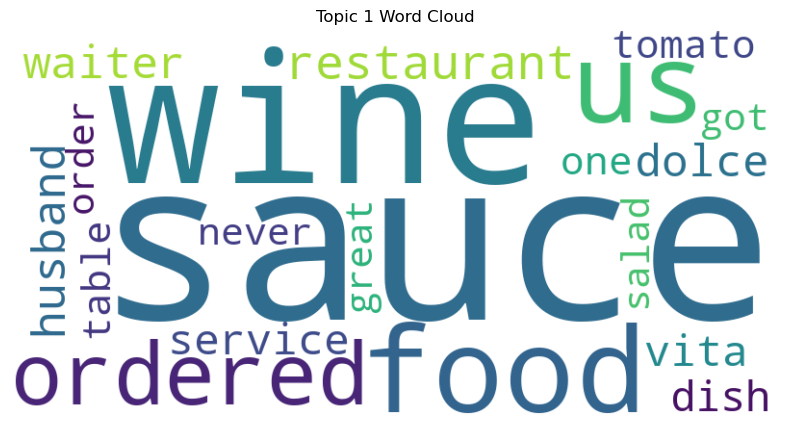

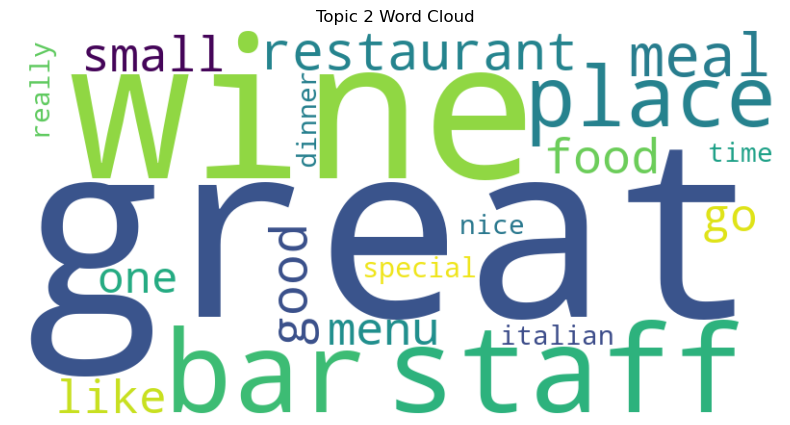

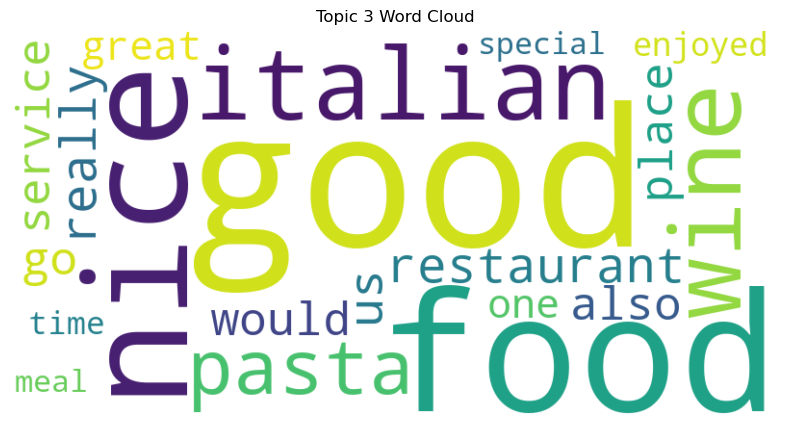

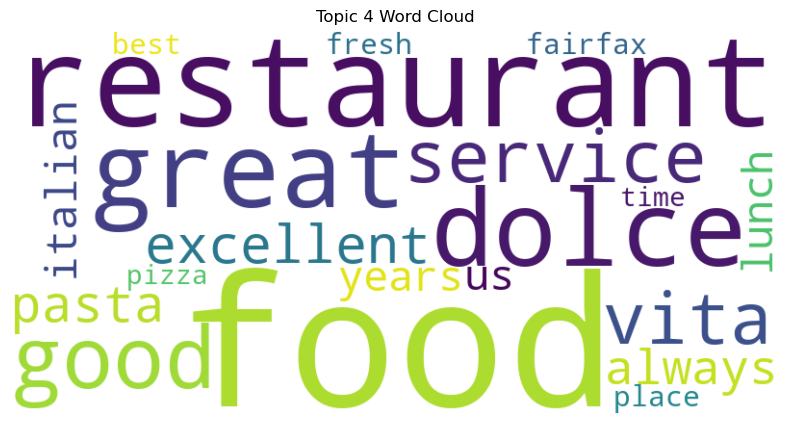

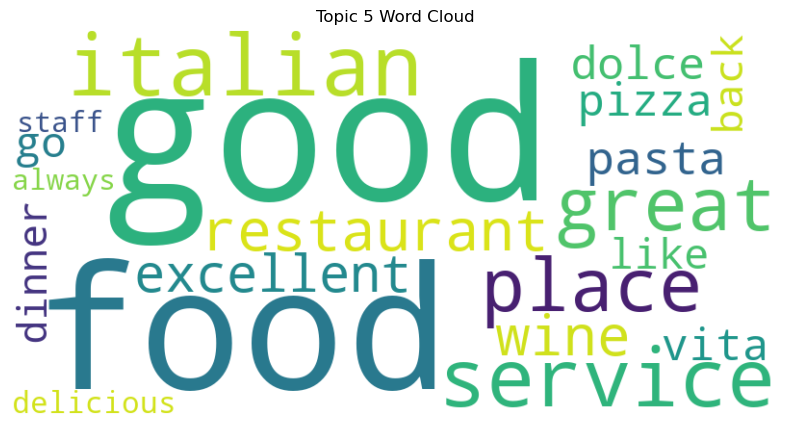

In [44]:
import pandas as pd
import re
import nltk
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Clean text: remove non-alphanumeric characters, convert to lowercase, remove stopwords
def preprocess_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W', ' ', str(text))
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_review'] = df['Review'].apply(preprocess_text)

# Create a list of lists of words for LDA input
processed_reviews = [review.split() for review in df['cleaned_review']]

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(processed_reviews)
corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train LDA model
num_topics = 5  # Set the number of topics
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
topics = lda_model.show_topics(num_topics=num_topics, num_words=5, formatted=False)
topic_names = []
for i, topic in topics:
    # Extract the top words for this topic
    top_words = [word for word, _ in topic]
    
    # Example logic to name topics based on keywords (you can modify this)
    if any(word in top_words for word in ['food', 'taste', 'delicious', 'flavor']):
        topic_name = "Food Quality"
    elif any(word in top_words for word in ['service', 'staff', 'friendly', 'waiter']):
        topic_name = "Customer Service"
    elif any(word in top_words for word in ['atmosphere', 'ambiance', 'decor', 'environment']):
        topic_name = "Ambiance"
    elif any(word in top_words for word in ['price', 'value', 'expensive', 'cost']):
        topic_name = "Pricing and Value"
    else:
        topic_name = "General Experience"
    
    topic_names.append((f"Topic {i+1}: {topic_name}", top_words))

# Display topics with names
for topic_name, words in topic_names:
    print(f"{topic_name} - Top Words: {', '.join(words)}")

# Display topics
topics = lda_model.print_topics(num_words=5)
for i, topic in topics:
    print(f"\n Topic {i+1}: {topic}")

# Visualize topics with WordClouds
for i, topic in topics:
    topic_words = dict(lda_model.show_topic(i, 20))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {i+1} Word Cloud')
    plt.show()


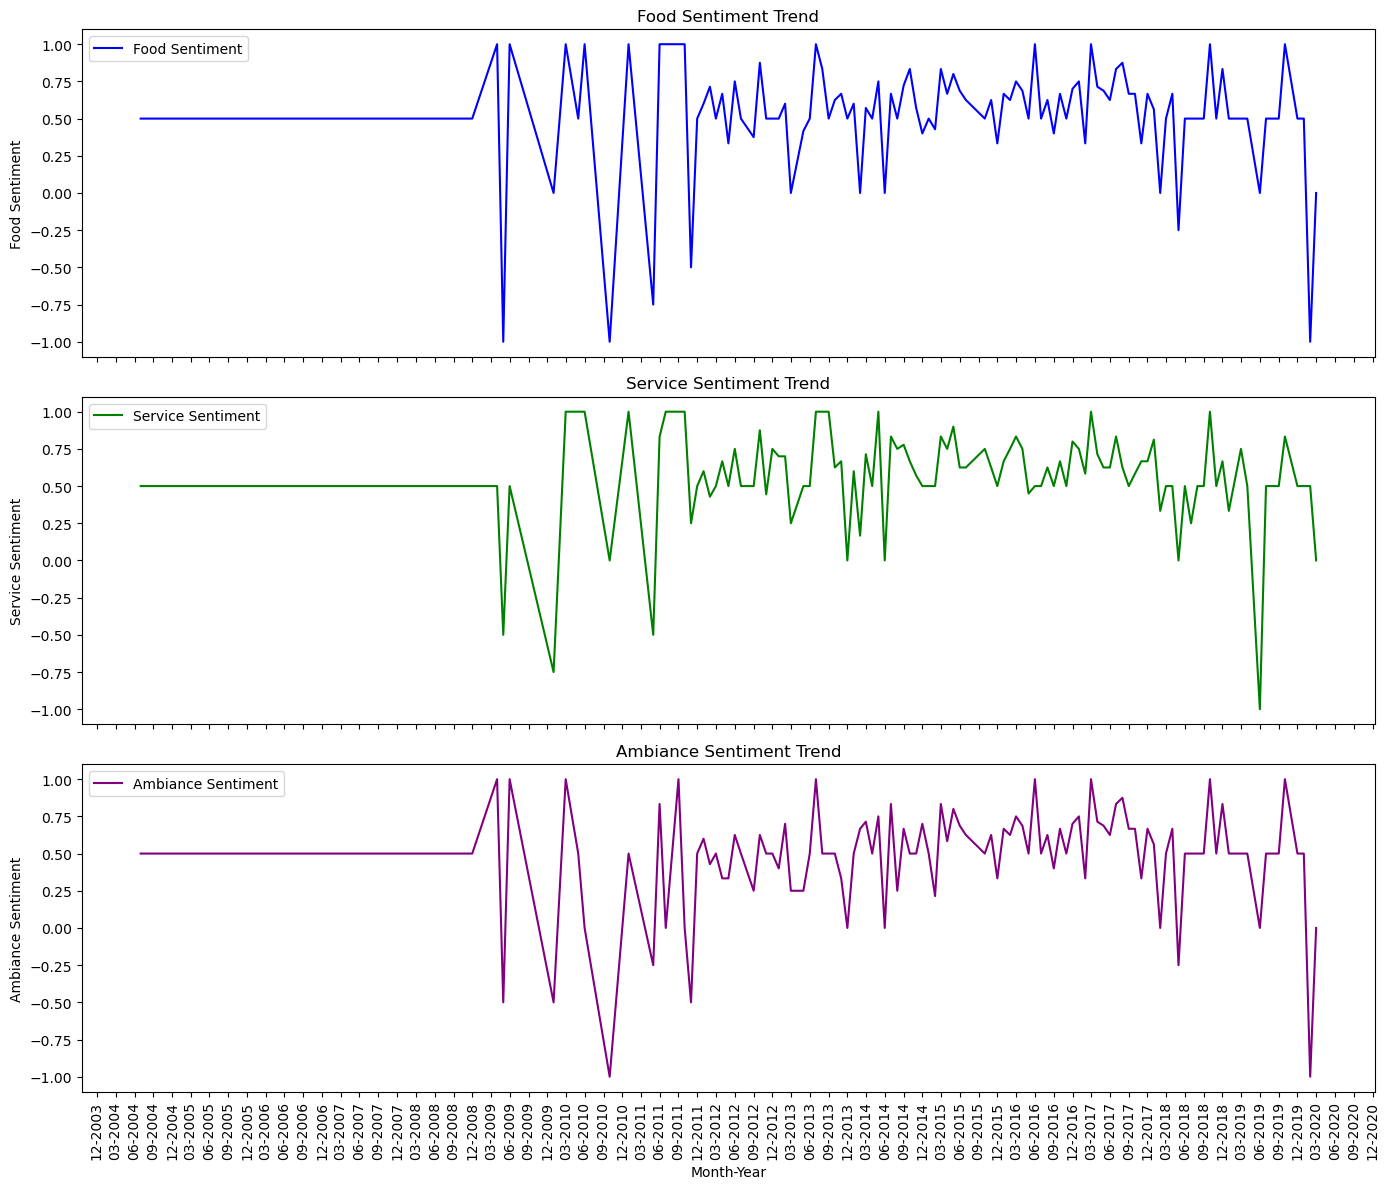

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'month_year' from Period to Timestamp if necessary
if isinstance(monthly_sentiment['month_year'].iloc[0], pd.Period):
    monthly_sentiment['month_year'] = monthly_sentiment['month_year'].dt.to_timestamp()

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot Food Sentiment
axs[0].plot(monthly_sentiment['month_year'], monthly_sentiment['food_sentiment'], label='Food Sentiment', color='blue')
axs[0].set_ylabel('Food Sentiment')
axs[0].set_title('Food Sentiment Trend')
axs[0].legend()

# Plot Service Sentiment
axs[1].plot(monthly_sentiment['month_year'], monthly_sentiment['service_sentiment'], label='Service Sentiment', color='green')
axs[1].set_ylabel('Service Sentiment')
axs[1].set_title('Service Sentiment Trend')
axs[1].legend()

# Plot Ambiance Sentiment
axs[2].plot(monthly_sentiment['month_year'], monthly_sentiment['ambiance_sentiment'], label='Ambiance Sentiment', color='purple')
axs[2].set_xlabel('Month-Year')
axs[2].set_ylabel('Ambiance Sentiment')
axs[2].set_title('Ambiance Sentiment Trend')
axs[2].legend()

# Set x-axis scale to show both month and year with spacing
for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show a tick every 3 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Format to show both month and year
    ax.tick_params(axis='x', rotation=90)  # Rotate and align the x-ticks

# Adjust layout
plt.tight_layout()
plt.show()
